In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess


def return_regr_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    Scores = namedtuple("Scores", ["mse", "mae", "rmse", "r2", "evs"])
    return Scores(mse, mae, rmse, r2, evs)


# Function to generate and plot time series, ACF, and PACF
def plot_series_with_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    axes[0].plot(series, label="Time Series")
    axes[0].set_title(f"{title} - Time Series")
    # axes[0].legend()
    plot_acf(series, lags=20, ax=axes[1], title="ACF")
    plot_pacf(series, lags=20, ax=axes[2], title="PACF")
    plt.tight_layout()
    plt.show()


def arima_forecast(train_series, predicted_series, p, d, q):
    """
    Forecasts a time series one timestep at a time using an ARIMA model.

    Parameters:
        train_series (pd.Series or np.array): The time series data for training.
        predicted_series (pd.Series or np.array): The actual series to compare the predictions.
        p (int): The order of the AR component.
        d (int): The order of differencing.
        q (int): The order of the MA component.

    Returns:
        np.array: The forecasted values.
    """
    train_series = np.array(train_series).copy()
    predicted_series = np.array(predicted_series).copy()
    steps = len(predicted_series)
    prediction = np.zeros(steps)

    # Forecast one timestep at a time
    for step in range(steps):
        # Fit the ARIMA model to the current data
        model = ARIMA(train_series, order=(p, d, q))
        model_fitted = model.fit()

        # Predict the next value and store it in prediction
        predicted_next_value = model_fitted.forecast(steps=1)
        prediction[step] = predicted_next_value[0]

        # Append the actual value to the train_series
        actual_next_value = np.array([predicted_series[step]])
        train_series = np.concatenate((train_series, actual_next_value))

    # Return only the forecasted values
    return prediction

# ARMA Process

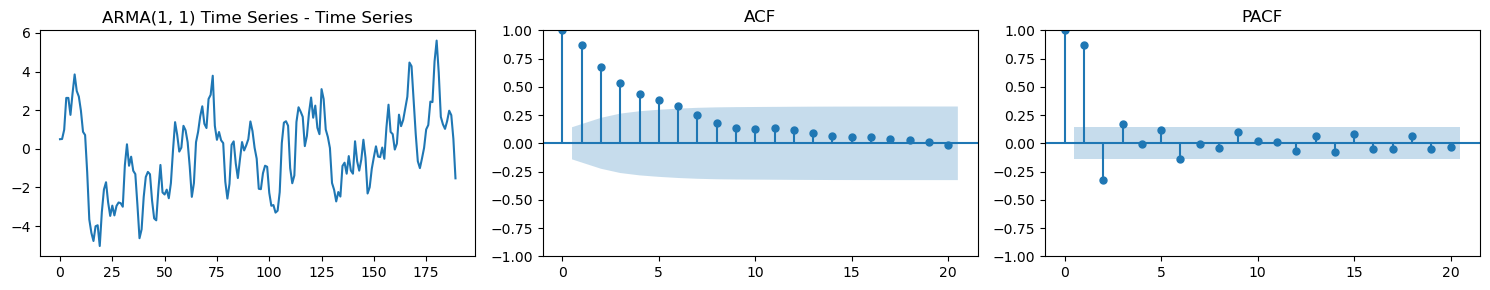

In [2]:
# Define the AR and MA coefficients
# For ARMA(p, q): AR coefficients should include 1 (for lag 0)
#                 MA coefficients should include 1 (for lag 0)
ar = np.array([1, -0.8])  # AR coefficients for AR(1) with phi=0.8
ma = np.array([1, 0.5])  # MA coefficients for MA(1) with theta=0.5

# Create the ARMA process
arma_process = ArmaProcess(ar, ma)
np.random.seed(42)  
arma11 = arma_process.generate_sample(nsample=200)

arma1_train = arma11[:190]
arma1_test = arma11[190:]
plot_series_with_acf_pacf(arma1_train, "ARMA(1, 1) Time Series")

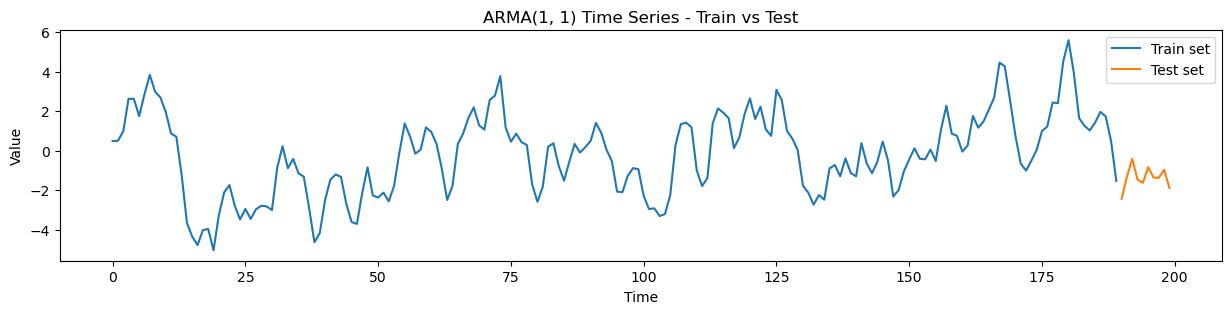

In [3]:
ax = plt.figure(figsize=(15, 3))
plt.plot(range(0, 190), arma1_train, label="Train set")
plt.plot(range(190, 200), arma1_test, label="Test set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("ARMA(1, 1) Time Series - Train vs Test")  
plt.legend()
plt.show()

### Step 1: Check for stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

# H0: a unit root is present (not stationary) 
# Ha: a unit root is not present (stationary)

result = adfuller(arma1_train)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.619622952093473
p-value: 0.005396772404170279


Here the p-value < 0.05, meaning that we can reject \(H_0\) (the series has a unit root). Therefore, the series is stationary.

### Step 2: Identify model parameters

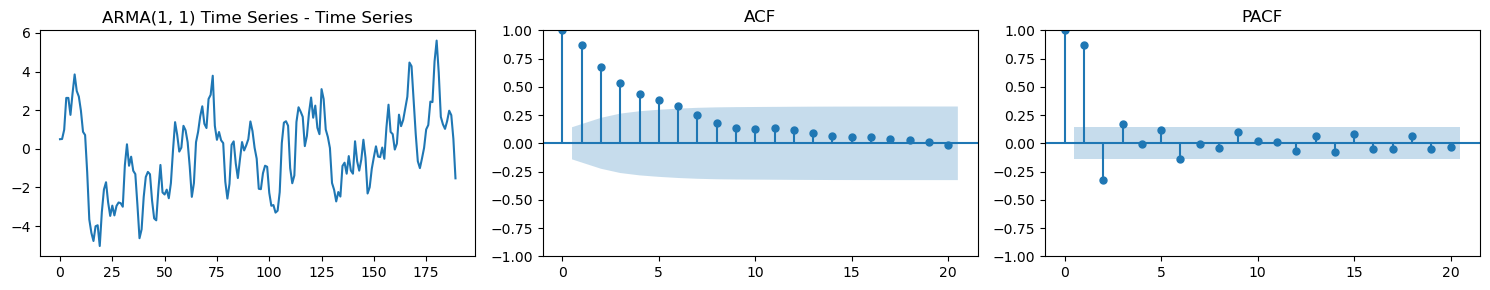

In [5]:
plot_series_with_acf_pacf(arma1_train, "ARMA(1, 1) Time Series")

### Step 3: Forecasting

In [6]:
forecast = arima_forecast(
    train_series=arma1_train, predicted_series=arma1_test, p=1, d=0, q=1
)

score = return_regr_score(arma1_test, forecast)

print("ARMA model:", score)

ARMA model: Scores(mse=0.46483859921906723, mae=0.5476565012026449, rmse=0.6817907297837564, r2=-0.6293829901650532, evs=-0.5060940753062957)


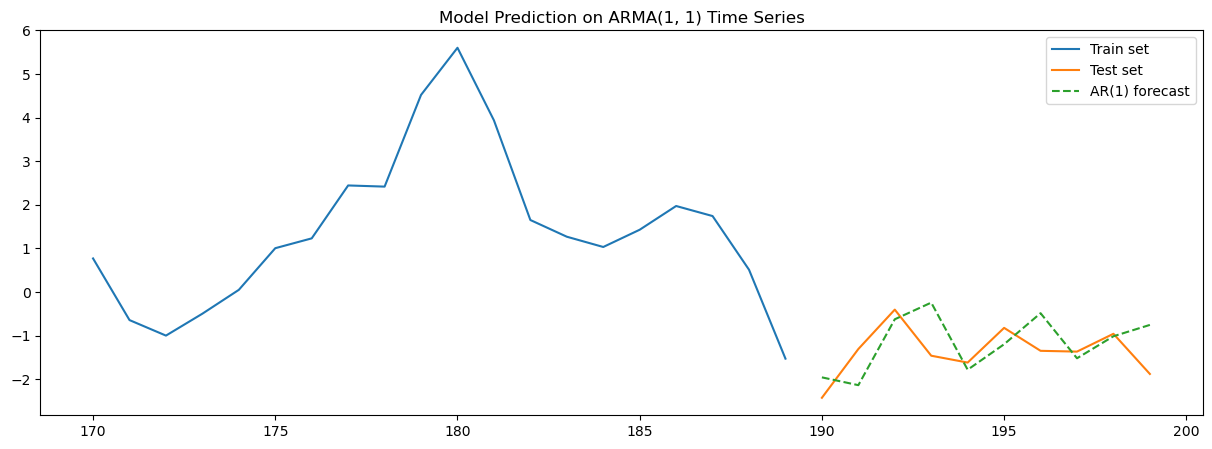

In [7]:
ax = plt.figure(figsize=(15, 5))
plt.plot(range(170, 190), arma1_train[170:190], label="Train set")
plt.plot(range(190, 200), arma1_test, label="Test set")
plt.plot(range(190, 200), forecast, label="AR(1) forecast", linestyle="--")
plt.title("Model Prediction on ARMA(1, 1) Time Series")
plt.legend()
plt.show()